In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")


In [2]:
son=pd.read_excel("./excel/FiyatPenceresi.Xlsx")
son=son[["Kod","Son.Fyt","Hcm","Yks","Dşk"]]
son.columns=["Hisse","Adj Close","Volume","High","Low"]
son=son.iloc[:-1,:]
son=son.dropna()


In [3]:
hisseler=son["Hisse"].values
hisseler=np.array(hisseler)

In [4]:
for i in range(len(hisseler)):
    hisseler[i]=hisseler[i]+".IS"

In [5]:
df=pd.DataFrame()
for hisse in hisseler:
    hisse_verileri = yf.download(hisse,start="2010-01-01")  # Örnek tarih aralığı
    hisse_kapanis = hisse_verileri[['High','Low','Open','Close','Volume']]
    hisse_kapanis["Hisse"]=hisse
    hisse_kapanis.loc[hisse_kapanis["Close"] > hisse_kapanis["High"], "High"] = hisse_kapanis["Close"]
    hisse_kapanis.loc[hisse_kapanis["Close"] < hisse_kapanis["Low"], "Low"] = hisse_kapanis["Close"]

    df=pd.concat([df,hisse_kapanis],axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,High,Low,Open,Close,Volume,Hisse
Date,,,,,,
2023-06-15,27.500000,27.500000,27.500000,27.500000,262214,A1CAP.IS
2023-06-16,30.240000,30.240000,30.240000,30.240000,1169499,A1CAP.IS
2023-06-20,31.100000,29.940001,31.000000,29.940001,8064437,A1CAP.IS
2023-06-21,26.959999,26.959999,26.959999,26.959999,2147415,A1CAP.IS
2023-06-22,27.620001,25.500000,25.620001,25.940001,71898180,A1CAP.IS
...,...,...,...,...,...,...
2024-05-27,7.470000,7.110000,7.110000,7.170000,2725387,ZRGYO.IS
2024-05-28,7.270000,7.040000,7.170000,7.220000,1321881,ZRGYO.IS
2024-05-29,7.610000,7.220000,7.220000,7.390000,4984541,ZRGYO.IS


In [6]:
ddata=df.copy()

In [7]:
df["Volume"]=df["Close"]*df["Volume"]

In [8]:
df["Close"]=np.round(df["Close"],2)
df["High"]=np.round(df["High"],2)
df["Low"]=np.round(df["Low"],2)
df["Open"]=np.round(df["Open"],2)

In [9]:
df.columns=['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse']

In [10]:
df["Kademe"] = np.where(df["Adj Close"] < 20, 0.01,
                np.where(df["Adj Close"] < 50, 0.02,
                    np.where(df["Adj Close"] < 100, 0.05,
                        np.where(df["Adj Close"] < 250, 0.1,
                            np.where(df["Adj Close"] < 500, 0.25,
                                np.where(df["Adj Close"] < 1000, 0.5,
                                    np.where(df["Adj Close"] < 2500, 1, 2.5)
                                )  # Buradaki parantez eksikti.
                            )
                        )
                    )
                )
            )


In [11]:
df=df.dropna()

In [12]:
import math
def yuvarla_asagi(row):
    fiyat = row['Adj Close']
    kadem = row['Kademe']
    return math.floor(fiyat * 1.1 / kadem) * kadem

df["Tavan"]=df.apply(yuvarla_asagi, axis=1)
df["Tavan"]=np.round(df["Tavan"],2)

In [13]:
df["Tavan Kontrol"]=np.where(((df["Adj Close"]/df["Tavan"].shift(1))==1),1,0)
df

,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Tavan Kontrol
Date,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0.02,30.24,0
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,0.02,33.26,1
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0.02,32.92,0
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0.02,29.64,0
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0.02,28.52,0
...,...,...,...,...,...,...,...,...,...
2024-05-27,7.47,7.11,7.11,7.17,1.954102e+07,ZRGYO.IS,0.01,7.88,0
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0.01,7.94,0
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,0.01,8.12,0


In [14]:
df=df.drop(["Kademe","Tavan"],axis=1)

In [15]:
import pandas_ta as ta
df["RSI"]=ta.rsi(df["Adj Close"],14)
df["SMA 5"]=df["Adj Close"].rolling(5).mean()
df["SMA 10"]=df["Adj Close"].rolling(5).mean()
df["SMA 200"]=df["Adj Close"].rolling(5).mean()



# Bağıl Hacim
df["Bağıl Hacim"] = df["Volume"] / df["Volume"].rolling(10).mean()



# ADX, DMI, Aroon
adx_data = ta.adx(df["High"], df["Low"], df["Adj Close"], 14)
df["ADX"], df["DMIP"], df["DMIN"] = adx_data.iloc[:, 0], adx_data.iloc[:, 1], adx_data.iloc[:, 2]




def calculate_stoch_rsi(data, rsi_period=14, stochastic_period=14, k_period=3, d_period=3):
    rsi = ta.rsi(data["Adj Close"], rsi_period)
    stoch_rsi = (rsi - rsi.rolling(window=stochastic_period).min()) / (rsi.rolling(window=stochastic_period).max() - rsi.rolling(window=stochastic_period).min())
    stoch_rsi_k = stoch_rsi.rolling(window=k_period).mean() * 100
    stoch_rsi_d = stoch_rsi_k.rolling(window=d_period).mean()
    data['StochRSI_%K'] = stoch_rsi_k
    data['StochRSI_%D'] = stoch_rsi_d
    return data

df = calculate_stoch_rsi(df)


def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['EMA_12'] = ta.ema(data['Adj Close'], short_period)
    data['EMA_26'] = ta.ema(data['Adj Close'], long_period)
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = ta.ema(data['MACD'], signal_period)
    data['MACD_above_Signal'] = (data['MACD'] > data['Signal_Line']).astype(float)
    return data

df = calculate_macd(df)



# Diğer Göstergeler
df["DD"] = ((df["Adj Close"] / df["High"]) - 1) * 100
df["Range"] = ((df["High"] - df["Low"]) / df["Adj Close"]) * 100

df["MOM"] = ta.mom(df["Adj Close"], 10)



df["Driehaus Momentum"] = ((df["Bağıl Hacim"] > 2) & (df["RSI"] > 50) & (df["MOM"] > 1) & (df["Adj Close"] > df["SMA 5"]) & (df["Adj Close"] > df["SMA 10"]) & (df["Adj Close"] > df["SMA 200"])).astype(int)
df["MACD Yukarı Kesen"] = ((df["Bağıl Hacim"] > 1.5) & (df["MACD"] > 0) & (df["MACD_above_Signal"] == 1)).astype(int)
df["ADXDMI20"] = ((df["Bağıl Hacim"] > 1.3) & (df["ADX"] > 20) & (df["DMIP"] > df["DMIN"])).astype(int)
df["MACD+Stoch"] = ((df["Bağıl Hacim"] > 1.3) & (df["StochRSI_%K"] > df["StochRSI_%D"]) & (df["MACD_above_Signal"] == 1)).astype(int)




In [16]:
df["Return"]=100*((df["Open"]/df["Adj Close"].shift(2))-1)
df["Return"]=df["Return"].shift(-2)
df["Gerçek Return"]=100*((df["Open"]/df["Open"].shift(1))-1)
df["Gerçek Return"]=df["Gerçek Return"].shift(-2)
df["Date"]=pd.to_datetime(df.index)
df


,High,Low,Open,Adj Close,Volume,Hisse,Tavan Kontrol,RSI,SMA 5,SMA 10,...,DD,Range,MOM,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,Return,Gerçek Return,Date
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,0,NaN,NaN,NaN,...,0.000000,0.000000,NaN,0,0,0,0,12.727273,2.513228,2023-06-15
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,1,NaN,NaN,NaN,...,0.000000,0.000000,NaN,0,0,0,0,-10.846561,-13.032258,2023-06-16
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,0,NaN,NaN,NaN,...,-3.729904,3.874415,NaN,0,0,0,0,-14.428858,-4.970326,2023-06-20
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,0,NaN,NaN,NaN,...,0.000000,0.000000,NaN,0,0,0,0,-3.041543,2.029664,2023-06-21
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,0,NaN,28.116,28.116,...,-6.082549,8.172706,NaN,0,0,0,0,-0.154202,-0.918133,2023-06-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,7.47,7.11,7.11,7.17,1.954102e+07,ZRGYO.IS,0,50.986440,7.346,7.346,...,-4.016064,5.020921,0.27,0,0,0,0,0.697350,0.697350,2024-05-27
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0,52.113252,7.256,7.256,...,-0.687758,3.185596,0.31,0,0,0,0,5.124654,5.124654,2024-05-28
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,0,55.831290,7.220,7.220,...,-2.890933,5.277402,0.46,0,0,1,0,7.036536,4.216074,2024-05-29


In [17]:
df=df[['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse', 'Bağıl Hacim', 'RSI','Driehaus Momentum', 'MACD Yukarı Kesen', 'ADXDMI20',
       'MACD+Stoch','DD','Range','Return',"Gerçek Return","Tavan Kontrol"]]

In [18]:
endeks=yf.download(tickers="XU100.IS",start="2000-01-01")
df["Endeks"]=endeks["Adj Close"]
df["Endeks Return"]=100*((df["Endeks"]/df["Endeks"].shift(1))-1)
df["Return Lag"]=((df["Adj Close"]/df["Adj Close"].shift(1))-1)*100
df

[*********************100%%**********************]  1 of 1 completed


,High,Low,Open,Adj Close,Volume,Hisse,Bağıl Hacim,RSI,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,DD,Range,Return,Gerçek Return,Tavan Kontrol,Endeks,Endeks Return,Return Lag
Date,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.210885e+06,A1CAP.IS,NaN,NaN,0,0,0,0,0.000000,0.000000,12.727273,2.513228,0,5495.500000,NaN,NaN
2023-06-16,30.24,30.24,30.24,30.24,3.536565e+07,A1CAP.IS,NaN,NaN,0,0,0,0,0.000000,0.000000,-10.846561,-13.032258,1,5475.500000,-0.363934,9.963636
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,NaN,NaN,0,0,0,0,-3.729904,3.874415,-14.428858,-4.970326,0,5251.600098,-4.089122,-0.992063
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,NaN,NaN,0,0,0,0,0.000000,0.000000,-3.041543,2.029664,0,5186.799805,-1.233915,-9.953240
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,NaN,NaN,0,0,0,0,-6.082549,8.172706,-0.154202,-0.918133,0,5428.299805,4.656050,-3.783383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,7.47,7.11,7.11,7.17,1.954102e+07,ZRGYO.IS,0.992988,50.986440,0,0,0,0,-4.016064,5.020921,0.697350,0.697350,0,10657.000000,-0.184516,0.985915
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0.493608,52.113252,0,0,0,0,-0.687758,3.185596,5.124654,5.124654,0,10677.500000,0.192362,0.697350
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,1.642738,55.831290,0,0,1,0,-2.890933,5.277402,7.036536,4.216074,0,10479.200195,-1.857174,2.354571


In [19]:
df=df.sort_index()

In [20]:
result = df.groupby('Hisse').apply(lambda x: x.iloc[2:])
result=result.droplevel(0)
result

,High,Low,Open,Adj Close,Volume,Hisse,Bağıl Hacim,RSI,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,DD,Range,Return,Gerçek Return,Tavan Kontrol,Endeks,Endeks Return,Return Lag
Date,,,,,,,,,,,,,,,,,,,,
2023-06-20,31.10,29.94,31.00,29.94,2.414492e+08,A1CAP.IS,NaN,NaN,0,0,0,0,-3.729904,3.874415,-14.428858,-4.970326,0,5251.600098,-4.089122,-0.992063
2023-06-21,26.96,26.96,26.96,26.96,5.789431e+07,A1CAP.IS,NaN,NaN,0,0,0,0,0.000000,0.000000,-3.041543,2.029664,0,5186.799805,-1.233915,-9.953240
2023-06-22,27.62,25.50,25.62,25.94,1.865039e+09,A1CAP.IS,NaN,NaN,0,0,0,0,-6.082549,8.172706,-0.154202,-0.918133,0,5428.299805,4.656050,-3.783383
2023-06-23,26.60,25.70,26.14,25.90,5.159935e+08,A1CAP.IS,NaN,NaN,0,0,0,0,-2.631579,3.474903,0.000000,0.000000,0,5582.799805,2.846195,-0.154202
2023-06-26,26.40,25.84,25.90,25.90,3.380095e+08,A1CAP.IS,NaN,NaN,0,0,0,0,-1.893939,2.162162,-0.694981,-0.694981,0,5732.899902,2.688617,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,7.47,7.11,7.11,7.17,1.954102e+07,ZRGYO.IS,0.992988,50.986440,0,0,0,0,-4.016064,5.020921,0.697350,0.697350,0,10657.000000,-0.184516,0.985915
2024-05-28,7.27,7.04,7.17,7.22,9.543981e+06,ZRGYO.IS,0.493608,52.113252,0,0,0,0,-0.687758,3.185596,5.124654,5.124654,0,10677.500000,0.192362,0.697350
2024-05-29,7.61,7.22,7.22,7.39,3.683576e+07,ZRGYO.IS,1.642738,55.831290,0,0,1,0,-2.890933,5.277402,7.036536,4.216074,0,10479.200195,-1.857174,2.354571


In [21]:


yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
for i in range(len(yasak)):
    yasak[i]=yasak[i]+".IS"

In [22]:

result = result[~result['Hisse'].isin(["ISATR.IS","ISBTR.IS"])]
result = result[~result['Hisse'].isin(yasak)]
result=result.sort_index()
val=result.loc["2023-07-01":"2023-12-31"].dropna()
train=result.loc[:"2023-06-30"].dropna()
test=result.loc["2024-01-01":].dropna()
X_train=train.drop(["High","Low","Open","Adj Close","Hisse","Return","Endeks","Tavan Kontrol","Gerçek Return"],axis=1)
X_test=test.drop(["High","Low","Open","Adj Close","Hisse","Return","Endeks","Tavan Kontrol","Gerçek Return"],axis=1)
X_val=val.drop(["High","Low","Open","Adj Close","Hisse","Return","Endeks","Tavan Kontrol","Gerçek Return"],axis=1)
X_train=X_train[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen"]]
X_test=X_test[["Endeks Return","Return Lag","Range","RSI","Volume","Bağıl Hacim","DD","MACD+Stoch","Driehaus Momentum","ADXDMI20","MACD Yukarı Kesen"]]
y_train=train["Return"]
y_test=test["Return"]
y_val=val["Return"]

In [354]:
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

def objective(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
    }
    

    model = CatBoostRegressor(**param, verbose=0,random_seed=123,task_type="GPU")

    # Modeli eğitme
    model.fit(X_train, y_train)





    

    model.fit(X_train, y_train)

        

    tahminler=pd.DataFrame()
    tahminler["Gerçek"]=val["Return"]
    tahminler["Tahmin"]=model.predict(X_val)
    tahminler["Hisse"]=val["Hisse"]
    tahminler["Tavan"]=val["Tavan Kontrol"]
    tahminler=tahminler[tahminler["Tavan"]==0]
    top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
    topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()/2).iloc[-1]
    returns=(top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()/2).diff().dropna()

    sharpe=topkar/returns.std()
    metrik=sharpe*topkar

    
    
        
       
    

    
    return metrik


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # n_trials, denenecek hiperparametre kombinasyonu sayısı

print('En iyi parametreler: ', study.best_params)
print('En iyi skor: ', study.best_value)


[I 2024-06-01 15:37:02,884] A new study created in memory with name: no-name-ab72c941-6524-4915-b597-5de872fc80ba
[I 2024-06-01 15:37:09,095] Trial 0 finished with value: 18159.36838770345 and parameters: {'iterations': 148, 'depth': 8, 'learning_rate': 0.163626900284044, 'random_strength': 3, 'bagging_temperature': 0.03638908954487763, 'border_count': 73, 'l2_leaf_reg': 4}. Best is trial 0 with value: 18159.36838770345.
[I 2024-06-01 15:37:37,511] Trial 1 finished with value: 9541.229188589303 and parameters: {'iterations': 687, 'depth': 10, 'learning_rate': 0.237295487661075, 'random_strength': 19, 'bagging_temperature': 0.40149148483116537, 'border_count': 86, 'l2_leaf_reg': 9}. Best is trial 0 with value: 18159.36838770345.
[I 2024-06-01 15:37:47,858] Trial 2 finished with value: 19981.83687742609 and parameters: {'iterations': 232, 'depth': 10, 'learning_rate': 0.0805180262692841, 'random_strength': 14, 'bagging_temperature': 0.5879862745361278, 'border_count': 210, 'l2_leaf_reg':

En iyi parametreler:  {'iterations': 554, 'depth': 7, 'learning_rate': 0.12307251987956724, 'random_strength': 8, 'bagging_temperature': 0.7091675055641468, 'border_count': 253, 'l2_leaf_reg': 19}
En iyi skor:  24630.254075570763


In [86]:
params = {'iterations': 629, 'depth': 8, 'learning_rate': 0.03984954027131234, 'random_strength': 3, 'bagging_temperature': 0.39823126184519836, 'border_count': 229, 'l2_leaf_reg': 19}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/xtumykapanis.bin")

In [41]:
bist100=pd.read_excel("./excel/bixt100.xlsx")
bist100=bist100["Kod"].values
for i in range(len(bist100)):
    bist100[i]=bist100[i]+".IS"

In [25]:
bist30=pd.read_excel("./excel/bist30.xlsx")
bist30=bist30["Kod"].values
for i in range(len(bist30)):
    bist30[i]=bist30[i]+".IS"

In [87]:
tahminler=pd.DataFrame()
tahminler["Gerçek"]=test["Return"]
tahminler["Tahmin"]=model.predict(X_test)
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(5, columns=['Tahmin'])).dropna()
(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2)


Date
2024-01-02     -0.912865
2024-01-03      0.061202
2024-01-04      0.713962
2024-01-05      4.258182
2024-01-08      6.488100
                 ...    
2024-05-23    103.886168
2024-05-24    104.223867
2024-05-27    105.220733
2024-05-28    103.581855
2024-05-29    104.645287
Name: Gerçek, Length: 102, dtype: float64

In [88]:
top_5_rows1=top_5_rows.copy()
top_5_rows1["Gerçek"]-=0.4

In [31]:
kar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).iloc[-1]
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).diff().dropna()

sharpe=kar/returns.std()
sharpe

51.98545650036941

In [808]:
sharpes=[]
metrik=[]
adet=[]
karlar=[]
for i in range(1,30):
   top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(i, columns=['Tahmin'])).dropna()
   topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).iloc[-1]
   returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).diff().dropna()
   sharpe=topkar/returns.std()
   metrik.append(sharpe*topkar)
   sharpes.append(sharpe)
   adet.append(i)
   karlar.append(topkar)
sonuc=pd.DataFrame()
sonuc["Adet"]=adet
sonuc["Sharpe*Kar"]=metrik
sonuc["Sharpe"]=sharpes
sonuc["Kar"]=karlar
sonuc.sort_values(by="Kar",ascending=False)


,Adet,Sharpe*Kar,Sharpe,Kar
0,1,8349.412711,45.867202,182.034490
1,2,6084.210989,46.243874,131.567936
2,3,6705.152795,53.561270,125.186590
3,4,5849.274370,54.508067,107.310252
4,5,6757.337233,64.573737,104.645287
5,6,6158.290415,66.360794,92.800132
6,7,6101.233141,69.467187,87.828994
7,8,4821.732780,64.258774,75.036178
8,9,4763.287935,64.309135,74.068605
9,10,4947.911120,67.535264,73.264112


In [89]:
top_5_rows=top_5_rows.droplevel(level=0)
top_5_rows1=top_5_rows1.droplevel(level=0)

In [90]:
indexler=df.index.unique()

In [ ]:
window_size=range(2,100)
vars=[]
top_5_rows["Var"]=0
size=[]
toplamkar=[]
import pandas as pd
for window in window_size:
   for index, group in top_5_rows.loc[:"2024-05-29"].groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-window:]
              getiriler=window_data.pct_change(window-1)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
   veri=top_5_rows[top_5_rows["Var"]>0]
   metrik=veri["Var"]
   veri["Metrik"]=metrik
   veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
   veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
   topkar=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
   toplamkar.append(topkar.iloc[-1])
   size.append(window)
   print("Window:{} Kar:{}".format(window,topkar.iloc[-1]))
optimizer=pd.DataFrame()
optimizer["Window Size"]=size
optimizer["Return"]=toplamkar
optimizer=optimizer.sort_values(by="Return",ascending=False)
optimizer





In [91]:

vars=[]
top_5_rows["Var"]=0

for index, group in top_5_rows.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-19:]
              getiriler=window_data.pct_change(18)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows[top_5_rows["Var"]>0]
veri=veri[veri["Tahmin"]>0]
metrik=veri["Var"]*veri["Tahmin"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
topkar






Date
2024-01-02     -0.511322
2024-01-03      0.307163
2024-01-04      0.761636
2024-01-05      4.700408
2024-01-08      8.543844
                 ...    
2024-05-22    148.045518
2024-05-23    148.463279
2024-05-24    149.686142
2024-05-27    150.517319
2024-05-28    151.469914
Name: Ağırlıklı Getiri, Length: 99, dtype: float64

In [92]:

vars=[]
top_5_rows1["Var"]=0

for index, group in top_5_rows1.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-19:]
              getiriler=window_data.pct_change(18)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows1.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows1[top_5_rows1["Var"]>0]
veri=veri[veri["Tahmin"]>0]
metrik=veri["Var"]*veri["Tahmin"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar1=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
topkar1






Date
2024-01-02     -0.711322
2024-01-03     -0.092837
2024-01-04      0.161636
2024-01-05      3.900408
2024-01-08      7.543844
                 ...    
2024-05-22    129.045518
2024-05-23    129.263279
2024-05-24    130.286142
2024-05-27    130.917319
2024-05-28    131.669914
Name: Ağırlıklı Getiri, Length: 99, dtype: float64

In [93]:
endeks=yf.download(tickers="XU100.IS",start="2023-12-29")
endeks["Getiri"]=0
for i in range(len(endeks)):
    endeks["Getiri"].iloc[i]=100*((endeks["Adj Close"].iloc[i]/endeks["Adj Close"].iloc[0])-1)
endeks=endeks.fillna(0)
endeks

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Getiri
Date,,,,,,,
2023-12-29,7415.299805,7510.399902,7415.299805,7470.200195,7470.200195,2664606500,0.000000
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,2.062858
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-0.779098
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,1.038789
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,2.121764
...,...,...,...,...,...,...,...
2024-05-27,10701.200195,10758.900391,10584.599609,10657.000000,10657.000000,2655557300,42.660166
2024-05-28,10678.799805,10721.200195,10589.700195,10677.500000,10677.500000,2872255400,42.934590
2024-05-29,10688.599609,10714.700195,10464.900391,10479.200195,10479.200195,2505729800,40.280045


In [94]:
bank=yf.download(tickers="XBANK.IS",start="2023-12-29")
bank["Getiri"]=0
for i in range(len(bank)):
    bank["Getiri"].iloc[i]=100*((bank["Adj Close"].iloc[i]/bank["Adj Close"].iloc[0])-1)
bank=bank.fillna(0)
bank

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Getiri
Date,,,,,,,
2023-12-29,8524.700195,8774.500000,8520.200195,8717.200195,8717.200195,1235400,0.000000
2024-01-02,8829.599609,8894.000000,8682.000000,8768.000000,8768.000000,767100,0.582754
2024-01-03,8750.500000,8785.799805,8489.299805,8489.299805,8489.299805,591700,-2.614376
2024-01-04,8498.000000,8727.500000,8392.599609,8711.500000,8711.500000,816400,-0.065390
2024-01-05,8720.599609,8790.700195,8644.599609,8789.900391,8789.900391,619100,0.833986
...,...,...,...,...,...,...,...
2024-05-27,15112.900391,15299.099609,14868.799805,15172.200195,15172.200195,707100,74.049005
2024-05-28,15209.900391,15509.599609,15128.599609,15456.299805,15456.299805,788500,77.308074
2024-05-29,15482.500000,15512.700195,14964.900391,14964.900391,14964.900391,663900,71.670950


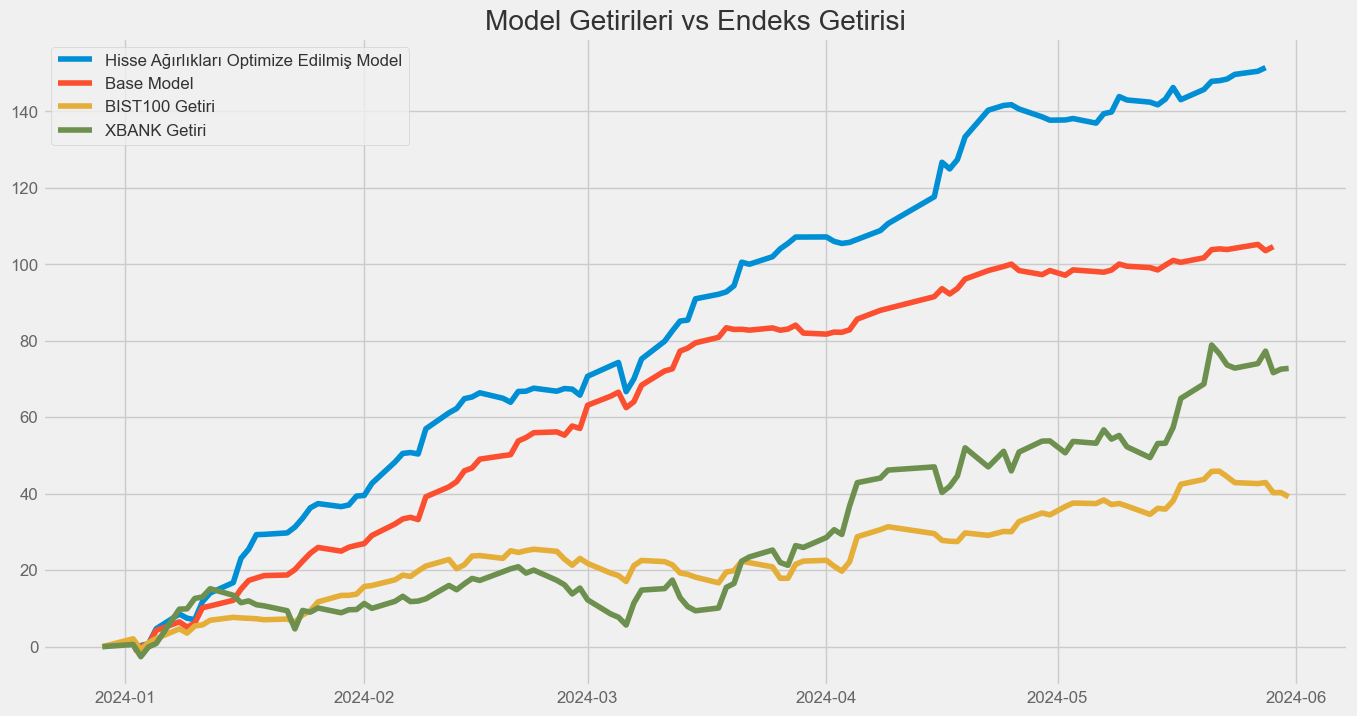

In [95]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Model Getirileri vs Endeks Getirisi")
plt.plot(topkar,label="Hisse Ağırlıkları Optimize Edilmiş Model")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Base Model")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
plt.plot(bank["Getiri"],label="XBANK Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

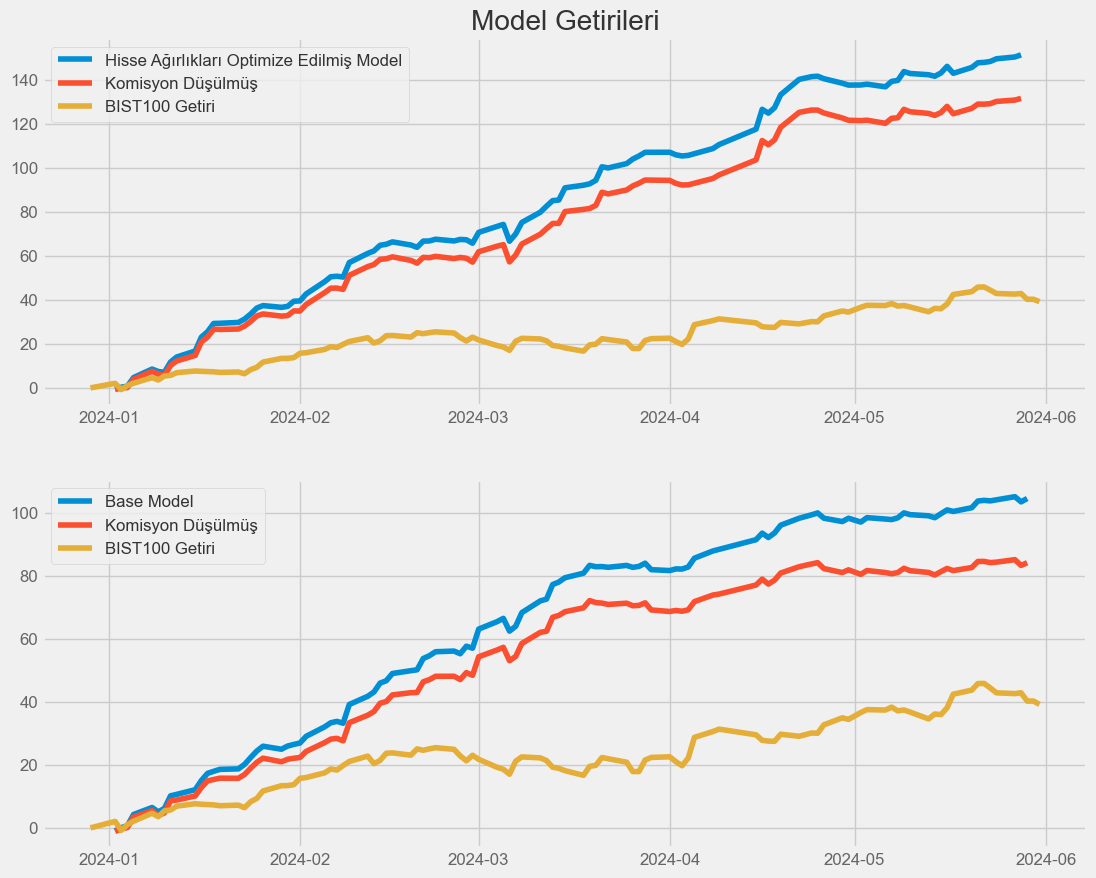

In [96]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title("Model Getirileri")
plt.plot(topkar,label="Hisse Ağırlıkları Optimize Edilmiş Model")
plt.plot(topkar1,label="Komisyon Düşülmüş")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")

plt.legend()
plt.subplot(2,1,2)
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Base Model")
plt.plot(top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Komisyon Düşülmüş")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
plt.legend()

In [815]:
kar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).iloc[-1]
returns=topkar.diff().dropna()

sharpe=topkar.iloc[-1]/returns.std()
sharpe

60.58480147365528

In [462]:
xtumy=pd.read_csv("BIST Tüm - 100 Geçmiş Verileri (8).csv")
xtumy=xtumy[::-1]
xtumy=xtumy.set_index(pd.to_datetime(yf.download(tickers="XU100.IS",start="2024-01-02",end="2024-05-30").index))
xtumy["Şimdi"]=xtumy["Şimdi"].str.replace(".","")
xtumy["Şimdi"]=xtumy["Şimdi"].str.replace(",",".")
xtumy["Şimdi"]=xtumy["Şimdi"].astype(float)
xtumy["Getiri"]=xtumy["Şimdi"].pct_change()*100
xtumy=xtumy.fillna(0)
xtumy

[*********************100%%**********************]  1 of 1 completed


,Tarih,Şimdi,Açılış,Yüksek,Düşük,Hac.,Fark %,Getiri
Date,,,,,,,,
2024-01-02,02.01.2024,26500.00,"25.981,61","26.559,05","25.981,61","1,51B","2,83%",0.000000
2024-01-03,03.01.2024,25773.09,"26.536,36","26.536,36","25.754,93","1,52B","-2,74%",-2.743057
2024-01-04,04.01.2024,26092.83,"25.774,39","26.092,83","25.601,14","1,24B","1,24%",1.240596
2024-01-05,05.01.2024,26632.97,"26.144,43","26.632,97","26.084,65","1,57B","2,07%",2.070071
2024-01-08,08.01.2024,27018.79,"26.762,93","27.026,95","26.762,93","1,61B","1,45%",1.448656
...,...,...,...,...,...,...,...,...
2024-05-23,23.05.2024,35926.66,"36.200,74","36.334,22","35.926,66","3,17B","-0,73%",-0.734928
2024-05-24,24.05.2024,35557.56,"35.975,05","36.006,72","35.514,53","2,62B","-1,03%",-1.027371
2024-05-27,27.05.2024,34941.10,"35.613,19","35.652,49","34.901,16","3,07B","-1,73%",-1.733696


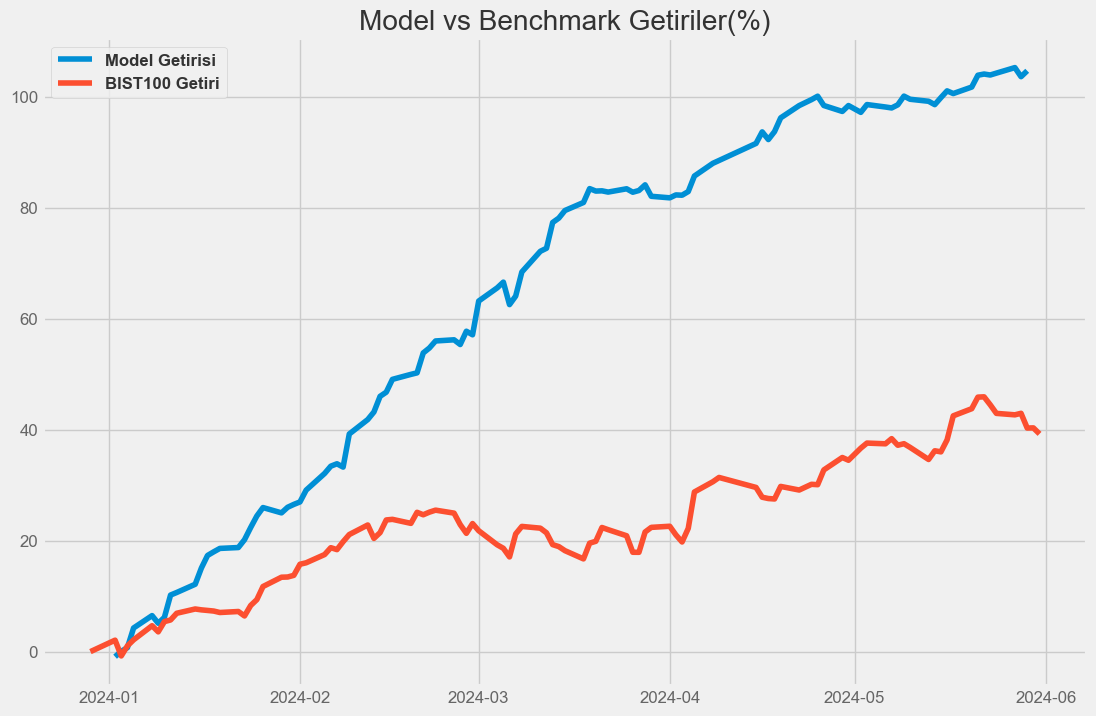

In [816]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.title("Model vs Benchmark Getiriler(%)")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Model Getirisi")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

In [817]:
veri["Para"]=100000*veri["Ağırlık"]
veri.groupby("Date")["Para"].sum()

Date
2024-01-02    100000.0
2024-01-03    100000.0
2024-01-04    100000.0
2024-01-05    100000.0
2024-01-08    100000.0
                ...   
2024-05-24    100000.0
2024-05-27    100000.0
2024-05-28    100000.0
2024-05-30    100000.0
2024-05-31    100000.0
Name: Para, Length: 101, dtype: float64

In [786]:
veri["Fiyat"]=0
for i in range(len(veri)):
    hisse=veri["Hisse"].iloc[i]
    time=pd.to_datetime(veri.index[i])
    fiyat=df[df["Hisse"]==hisse].loc[time]["Adj Close"]
    veri["Fiyat"].iloc[i]=fiyat

In [787]:
veri["Lot"]=veri["Para"]//veri["Fiyat"]
veri

,Gerçek,Tahmin,Hisse,Tavan,Var,Metrik,Ağırlık,Ağırlıklı Getiri,Para,Fiyat,Lot
Date,,,,,,,,,,,
2024-01-02,1.968504,1.188652,ANSGR.IS,0,4.700516,4.700516,0.521522,1.026619,52152.228520,63.50,821.0
2024-01-02,-1.450512,1.159306,TCELL.IS,0,4.312553,4.312553,0.478478,-0.694038,47847.771480,58.60,816.0
2024-01-03,2.908277,1.142826,YEOTK.IS,0,0.249701,0.249701,0.334649,0.973252,33464.878904,178.80,187.0
2024-01-03,3.010949,0.883266,CWENE.IS,0,0.496457,0.496457,0.665351,2.003339,66535.121096,274.00,242.0
2024-01-04,4.745763,1.268618,TCELL.IS,0,2.521989,2.521989,0.375419,1.781647,37541.857494,59.00,636.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-29,0.181818,0.815455,ANSGR.IS,0,2.556104,2.556104,0.050024,0.009095,5002.364747,110.00,45.0
2024-05-30,-73.275862,0.931293,ANSGR.IS,0,1.311355,1.311355,0.028384,-2.079846,2838.377851,110.20,25.0
2024-05-30,76.090468,0.802890,ALBRK.IS,0,44.889516,44.889516,0.971616,73.930733,97161.622149,6.19,15696.0


In [818]:
ağırlıklar=((100*(veri.loc[:"2024-05-29"].groupby('Hisse')["Para"].sum().sort_values(ascending=True)/veri.loc[:"2024-05-29"]["Para"].sum())))

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'ANHYT.IS'),
  Text(0, 1, 'DNISI.IS'),
  Text(0, 2, 'ALBRK.IS'),
  Text(0, 3, 'ATLAS.IS'),
  Text(0, 4, 'SILVR.IS'),
  Text(0, 5, 'BMSTL.IS'),
  Text(0, 6, 'BASGZ.IS'),
  Text(0, 7, 'BSOKE.IS'),
  Text(0, 8, 'IHAAS.IS'),
  Text(0, 9, 'ISFIN.IS'),
  Text(0, 10, 'IZINV.IS'),
  Text(0, 11, 'SANEL.IS'),
  Text(0, 12, 'AKYHO.IS'),
  Text(0, 13, 'MTRKS.IS'),
  Text(0, 14, 'SELGD.IS'),
  Text(0, 15, 'TDGYO.IS'),
  Text(0, 16, 'DOGUB.IS'),
  Text(0, 17, 'ANELE.IS'),
  Text(0, 18, 'SEKUR.IS'),
  Text(0, 19, 'FONET.IS'),
  Text(0, 20, 'PINSU.IS'),
  Text(0, 21, 'METUR.IS'),
  Text(0, 22, 'ERSU.IS'),
  Text(0, 23, 'AKENR.IS'),
  Text(0, 24, 'ZEDUR.IS'),
  Text(0, 25, 'TSGYO.IS'),
  Text(0, 26, 'IZFAS.IS'),
  Text(0, 27, 'TRILC.IS'),
  Text(0, 28, 'BAYRK.IS'),
  Text(0, 29, 'JANTS.IS')])

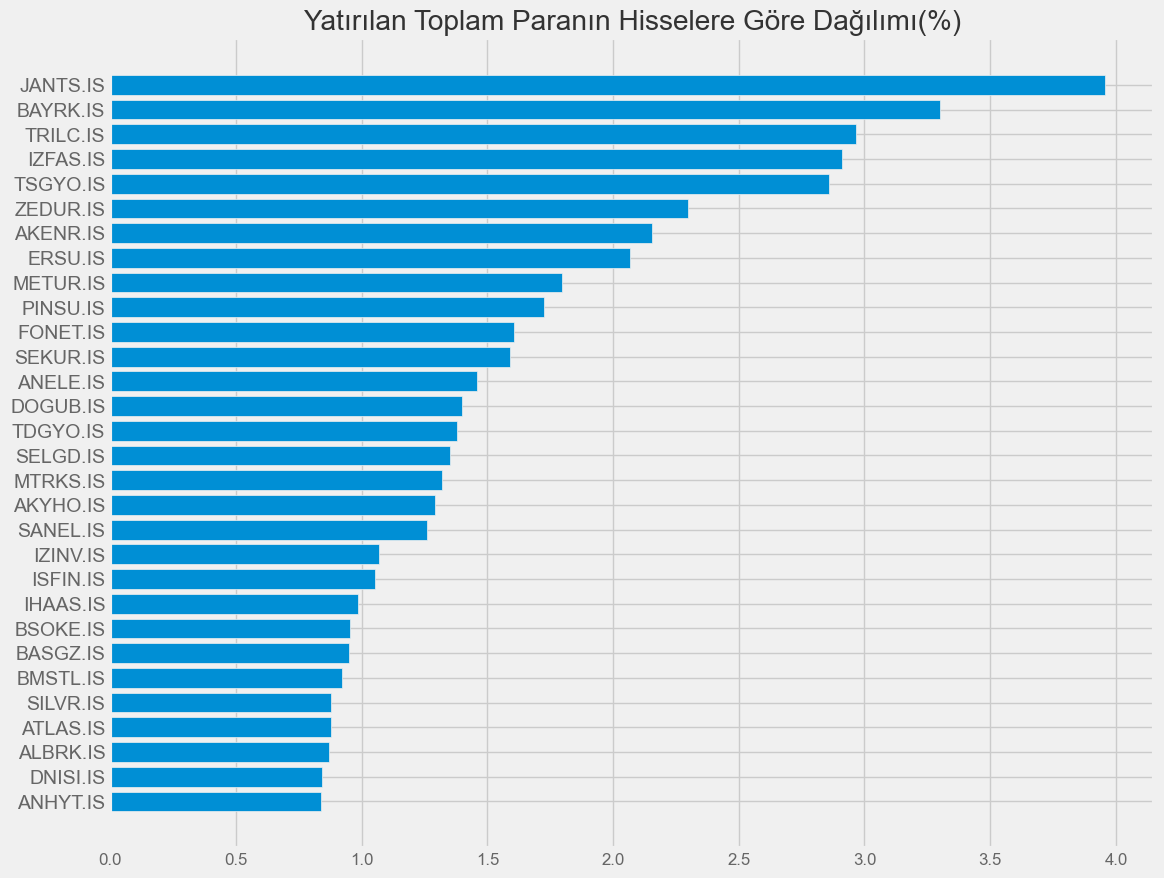

In [819]:
plt.figure(figsize=(12,10))
plt.title("Yatırılan Toplam Paranın Hisselere Göre Dağılımı(%)")
plt.barh(ağırlıklar.tail(30).index,ağırlıklar.tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'AKYHO.IS'),
  Text(0, 1, 'DOFER.IS'),
  Text(0, 2, 'TDGYO.IS'),
  Text(0, 3, 'BASGZ.IS'),
  Text(0, 4, 'AGROT.IS'),
  Text(0, 5, 'MAGEN.IS'),
  Text(0, 6, 'BSOKE.IS'),
  Text(0, 7, 'MAVI.IS'),
  Text(0, 8, 'IHAAS.IS'),
  Text(0, 9, 'DESPC.IS'),
  Text(0, 10, 'ESCAR.IS'),
  Text(0, 11, 'ZEDUR.IS'),
  Text(0, 12, 'GRSEL.IS'),
  Text(0, 13, 'METUR.IS'),
  Text(0, 14, 'KTLEV.IS'),
  Text(0, 15, 'PAPIL.IS'),
  Text(0, 16, 'ERSU.IS'),
  Text(0, 17, 'BMSTL.IS'),
  Text(0, 18, 'ANHYT.IS'),
  Text(0, 19, 'SELGD.IS'),
  Text(0, 20, 'TSGYO.IS'),
  Text(0, 21, 'RALYH.IS'),
  Text(0, 22, 'MTRKS.IS'),
  Text(0, 23, 'RAYSG.IS'),
  Text(0, 24, 'JANTS.IS'),
  Text(0, 25, 'PINSU.IS'),
  Text(0, 26, 'BAYRK.IS'),
  Text(0, 27, 'TRILC.IS'),
  Text(0, 28, 'IZFAS.IS'),
  Text(0, 29, 'UFUK.IS')])

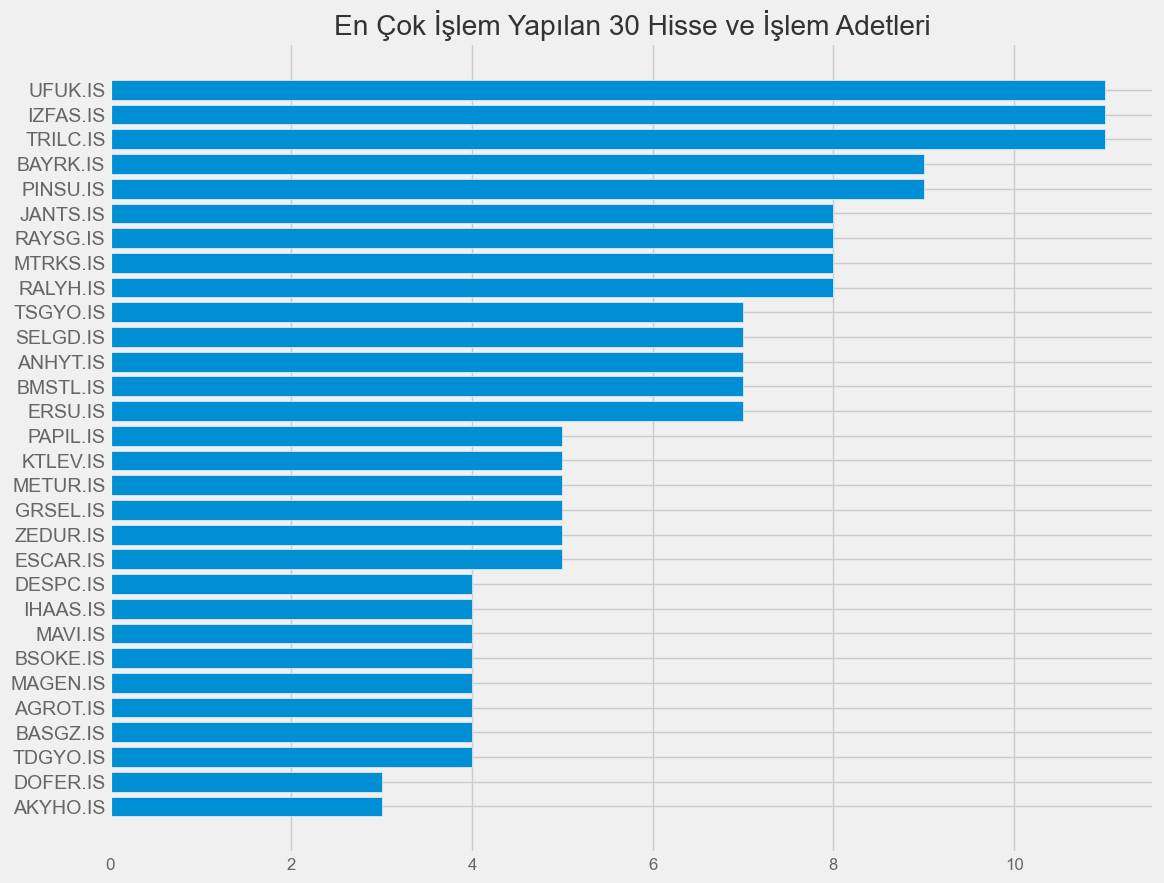

In [820]:
plt.figure(figsize=(12,10))
plt.title("En Çok İşlem Yapılan 30 Hisse ve İşlem Adetleri")
plt.barh(veri["Hisse"].value_counts().sort_values().tail(30).index,veri["Hisse"].value_counts().sort_values().tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [821]:

returns=topkar.diff().dropna()
returns=returns/100
returns=pd.DataFrame(returns)
returns["Kar"]=np.where((returns>0),1,0)
returns
returns

,Ağırlıklı Getiri,Kar
Date,,
2024-01-03,0.008185,1
2024-01-04,0.004545,1
2024-01-05,0.039388,1
2024-01-08,0.038434,1
2024-01-09,-0.010874,0
...,...,...
2024-05-22,0.001610,1
2024-05-23,0.004178,1
2024-05-24,0.012229,1


In [822]:
returns["Ağırlıklı Getiri"].mean()*100

1.550828943355797

In [823]:
def ortalama_kazanma_serisi_uzunlugu(veri):
    kazanma_serileri = []  # Kazanma serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kazanma serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 1:  # Eğer 1 görürsek,
            current_series_length += 1  # Kazanma serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kazanma serisi bitmişse,
                kazanma_serileri.append(current_series_length)  # Kazanma serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kazanma serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kazanma serisi varsa,
        kazanma_serileri.append(current_series_length)  # Son kazanma serisini de listeye ekle.
    
    # Kazanma serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kazanma_serileri) / len(kazanma_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kazanma serisi uzunluğunu bul
ortalama = ortalama_kazanma_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kazanma serisi uzunluğu:", ortalama)


Ortalama kazanma serisi uzunluğu: 5.066666666666666


In [824]:
def ortalama_kaybetme_serisi_uzunlugu(veri):
    kaybetme_serileri = []  # Kaybetme serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kaybetme serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 0:  # Eğer 0 görürsek,
            current_series_length += 1  # Kaybetme serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kaybetme serisi bitmişse,
                kaybetme_serileri.append(current_series_length)  # Kaybetme serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kaybetme serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kaybetme serisi varsa,
        kaybetme_serileri.append(current_series_length)  # Son kaybetme serisini de listeye ekle.
    
    # Kaybetme serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kaybetme_serileri) / len(kaybetme_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kaybetme serisi uzunluğunu bul
ortalama = ortalama_kaybetme_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kaybetme serisi uzunluğu:", ortalama)


Ortalama kaybetme serisi uzunluğu: 1.5714285714285714


In [825]:
endeks["Return"]=(endeks["Adj Close"]/endeks["Adj Close"].shift(1))-1
endeks

,Open,High,Low,Close,Adj Close,Volume,Getiri,Return
Date,,,,,,,,
2023-12-29,7415.299805,7510.399902,7415.299805,7470.200195,7470.200195,2664606500,0.000000,NaN
2024-01-02,7542.299805,7634.100098,7542.299805,7624.299805,7624.299805,2397081700,2.062858,0.020629
2024-01-03,7624.600098,7624.600098,7411.799805,7412.000000,7412.000000,2169646100,-0.779098,-0.027845
2024-01-04,7421.899902,7547.799805,7387.000000,7547.799805,7547.799805,2391591200,1.038789,0.018322
2024-01-05,7570.100098,7628.700195,7532.200195,7628.700195,7628.700195,2355101900,2.121764,0.010718
...,...,...,...,...,...,...,...,...
2024-05-27,10701.200195,10758.900391,10584.599609,10657.000000,10657.000000,2655557300,42.660166,-0.001845
2024-05-28,10678.799805,10721.200195,10589.700195,10677.500000,10677.500000,2872255400,42.934590,0.001924
2024-05-29,10688.599609,10714.700195,10464.900391,10479.200195,10479.200195,2505729800,40.280045,-0.018572


In [826]:
endeks["Kar"]=np.where((endeks["Return"]>0),1,0)
xtumy["Kar"]=np.where((xtumy["Getiri"]>0),1,0)

In [795]:
returns[returns["Ağırlıklı Getiri"]>0]

,Ağırlıklı Getiri,Kar
Date,,
2024-01-03,0.014883,1
2024-01-04,0.016763,1
2024-01-05,0.021555,1
2024-01-08,0.010459,1
2024-01-09,0.014968,1
...,...,...
2024-05-17,0.002499,1
2024-05-20,0.011620,1
2024-05-21,0.022876,1


In [ ]:
qs.reports.full(returns=returns["Ağırlıklı Getiri"],benchmark=endeks["Return"])

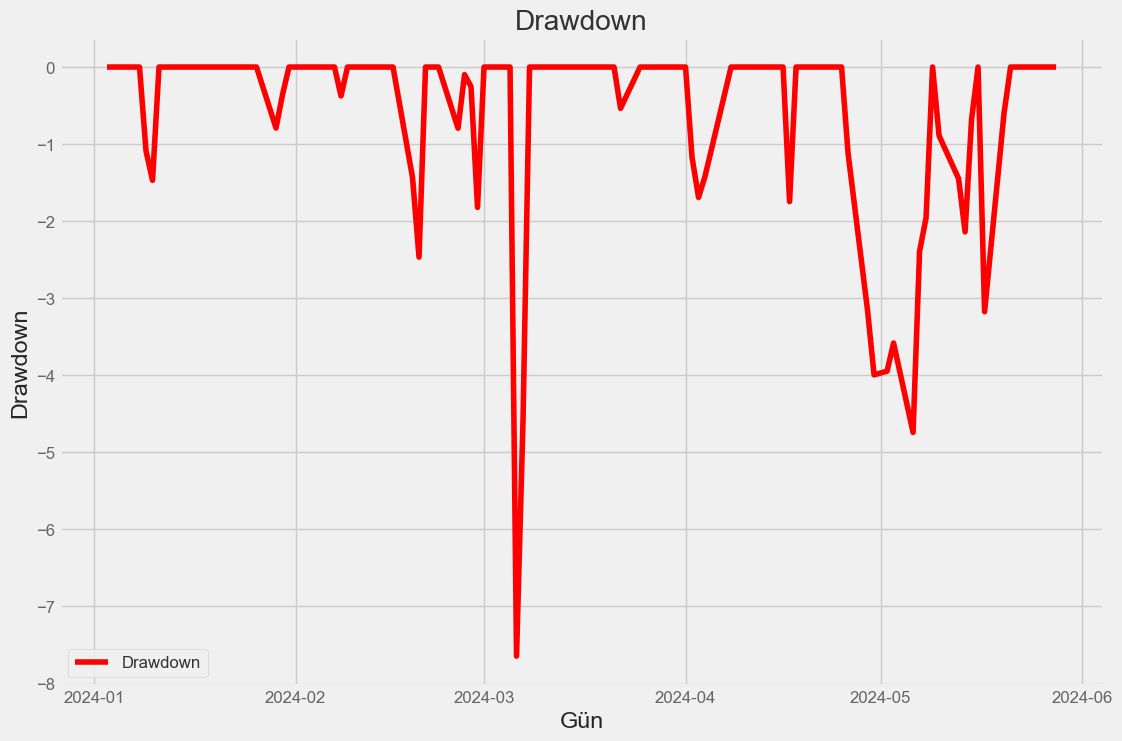

In [829]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame
cumulative_returns = np.cumprod(1+returns["Ağırlıklı Getiri"])


def calculate_drawdowns(returns):
    peak = returns[0]
    drawdowns = [0]  # İlk değer 0, çünkü başlangıçta herhangi bir drawdown yok

    for ret in returns[1:]:
        if ret > peak:
            peak = ret
            drawdowns.append(0)  # Yeni zirve bulunduğunda drawdown sıfırlanır
        else:
            drawdowns.append(-100*((peak - ret) / peak))  # Drawdown hesaplanır
    
    return drawdowns

# Drawdown'ları hesapla
drawdowns = calculate_drawdowns(cumulative_returns)


# Grafik çizimi
plt.figure(figsize=(12, 8))
plt.plot(returns.index, drawdowns, label='Drawdown', color='red', linestyle='-')
plt.xlabel('Gün')
plt.ylabel('Drawdown')
plt.title('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [830]:
feature_importance = model.get_feature_importance(type='FeatureImportance')

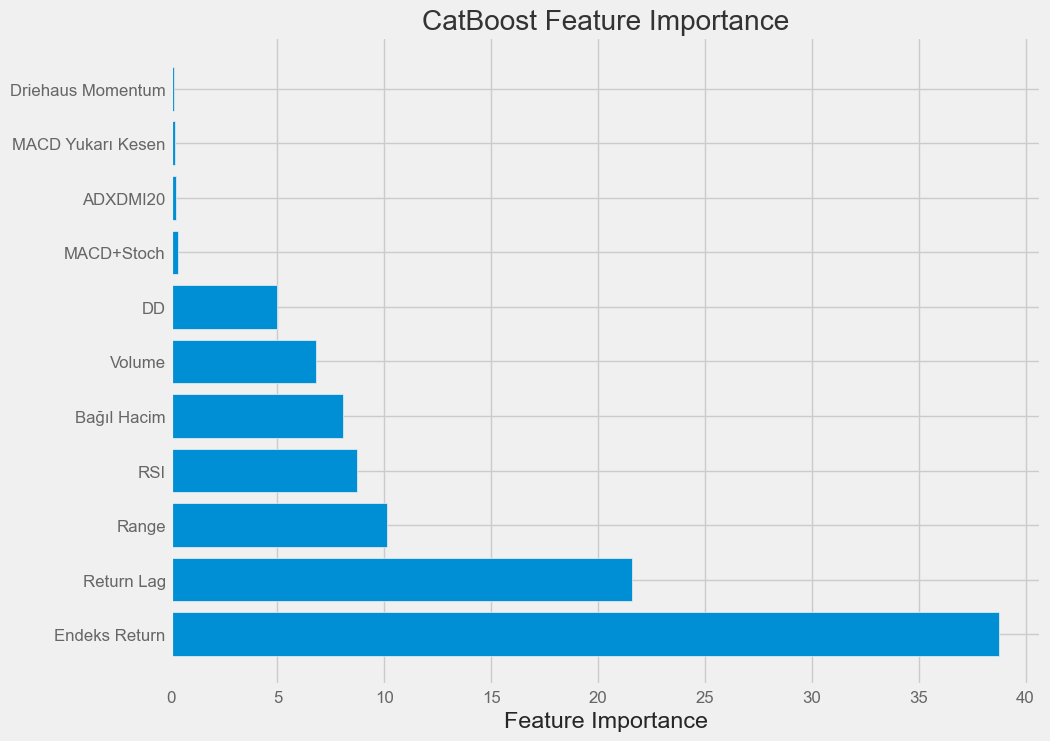

In [831]:
import catboost
feature_importance = model.get_feature_importance(type='FeatureImportance')
# Özellik isimlerini alın
feature_names = model.feature_names_

# Özellik önemlerini bir sözlükte saklayın
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Özellik önemlerine göre sıralayın
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Görselleştirme
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.yticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [42]:
params={'iterations': 571,
 'depth': 5,
 'learning_rate': 0.05514261151828995,
 'random_strength': 4,
 'bagging_temperature': 0.9572252022114495,
 'border_count': 59,
 'l2_leaf_reg': 20}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=123)
model.load_model("./model/bist100model.bin")

In [79]:
tahminler=pd.DataFrame()
tahminler["Gerçek"]=test["Return"]
tahminler["Tahmin"]=model.predict(X_test)
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
tahminler=tahminler[tahminler["Hisse"].isin(bist100)]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(2, columns=['Tahmin'])).dropna()
(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2)

Date
2024-01-02     0.129498
2024-01-03     1.609305
2024-01-04     3.424556
2024-01-05     6.743600
2024-01-08     8.461784
                ...    
2024-05-23    61.967345
2024-05-24    62.689023
2024-05-27    62.280927
2024-05-28    61.043210
2024-05-29    60.382228
Name: Gerçek, Length: 102, dtype: float64

In [80]:
top_5_rows1=top_5_rows.copy()
top_5_rows1["Gerçek"]-=0.4

In [81]:
top_5_rows=top_5_rows.droplevel(level=0)
top_5_rows1=top_5_rows1.droplevel(level=0)

In [56]:

vars=[]
top_5_rows["Var"]=0

for index, group in top_5_rows.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-10:]
              getiriler=window_data.pct_change(9)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows[top_5_rows["Var"]>0]
metrik=veri["Var"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
topkar

Date
2024-01-02     0.166291
2024-01-03     1.654586
2024-01-04     3.330897
2024-01-05     5.486359
2024-01-08     6.532252
                ...    
2024-05-23    83.270975
2024-05-24    85.022448
2024-05-27    83.835820
2024-05-28    81.472895
2024-05-29    80.135247
Name: Ağırlıklı Getiri, Length: 102, dtype: float64

In [67]:
vars=[]
top_5_rows1["Var"]=0

for index, group in top_5_rows1.groupby(level=0):
       hisseler=group["Hisse"]
       for hisse in hisseler:
           try:
              window_data=df[df["Hisse"]==hisse]["Adj Close"].loc[indexler[-500]:].loc[:index].iloc[-10:]
              getiriler=window_data.pct_change(9)*100
              getiri=getiriler.iloc[-1]
              std=window_data.std()
              var=getiri/std
              vars.append(var)
              top_5_rows1.loc[(top_5_rows["Hisse"]==hisse) & (top_5_rows.index==index), "Var"] = var
           except Exception as e:
               print(e)
veri=top_5_rows1[top_5_rows1["Var"]>0]
metrik=veri["Var"]
veri["Metrik"]=metrik
veri['Ağırlık'] = veri['Metrik'] / veri.groupby(level=0)['Metrik'].transform('sum')
veri["Ağırlıklı Getiri"]=veri["Ağırlık"]*veri["Gerçek"]
topkar1=veri.groupby('Date')["Ağırlıklı Getiri"].sum().iloc[:-2].cumsum()/2
topkar1

Date
2024-01-02    -0.033709
2024-01-03     1.254586
2024-01-04     2.730897
2024-01-05     4.686359
2024-01-08     5.532252
                ...    
2024-05-23    63.670975
2024-05-24    65.222448
2024-05-27    63.835820
2024-05-28    61.272895
2024-05-29    59.735247
Name: Ağırlıklı Getiri, Length: 102, dtype: float64

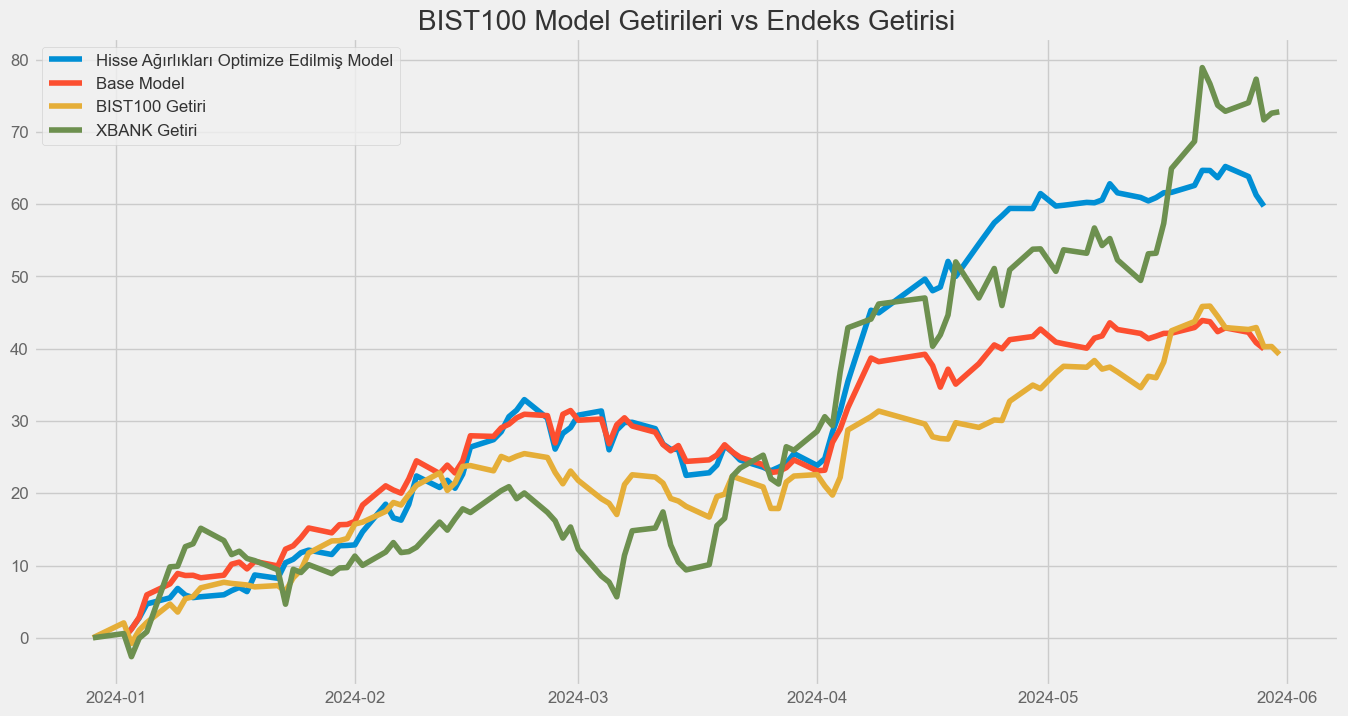

In [48]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("BIST100 Model Getirileri vs Endeks Getirisi")
plt.plot(topkar,label="Hisse Ağırlıkları Optimize Edilmiş Model")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Base Model")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
plt.plot(bank["Getiri"],label="XBANK Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

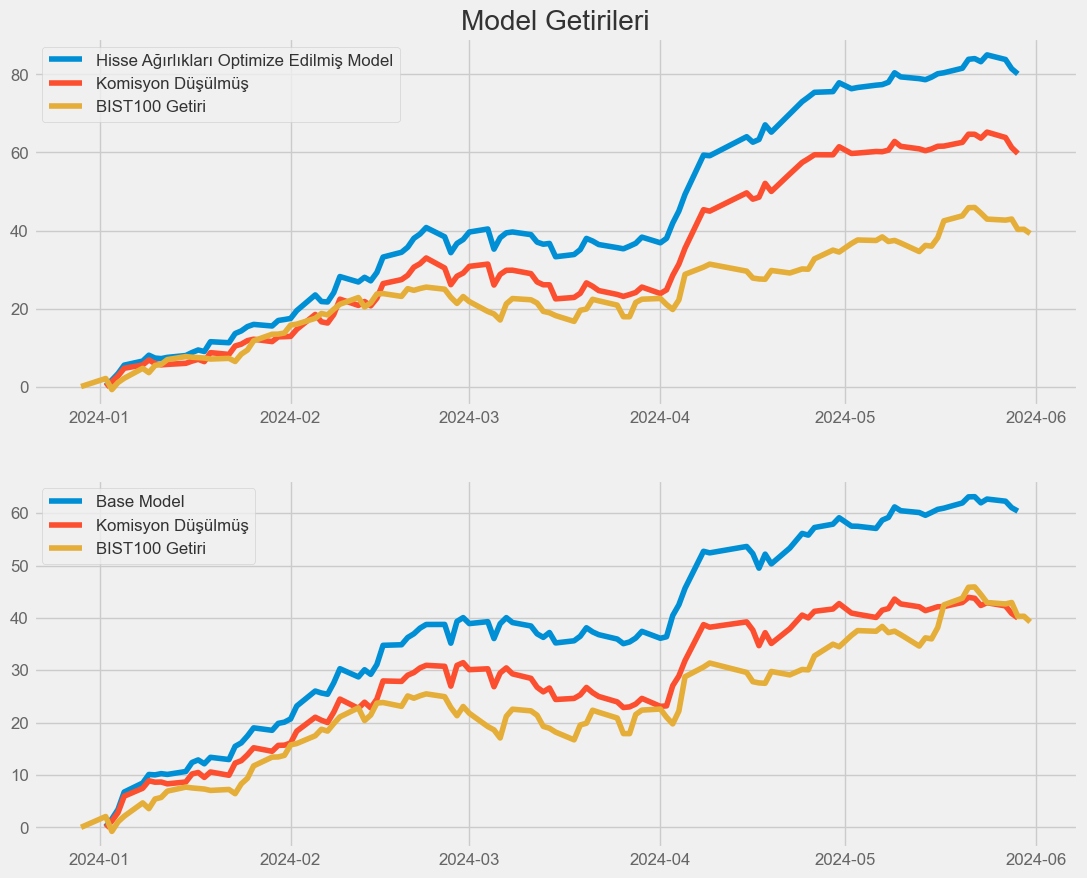

In [85]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title("Model Getirileri")
plt.plot(topkar,label="Hisse Ağırlıkları Optimize Edilmiş Model")
plt.plot(topkar1,label="Komisyon Düşülmüş")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")

plt.legend()
plt.subplot(2,1,2)
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Base Model")
plt.plot(top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2,label="Komisyon Düşülmüş")
plt.plot(endeks["Getiri"],label="BIST100 Getiri")
plt.legend()